<a href="https://colab.research.google.com/github/Attabeezy/sequential-crm-for-dce/blob/main/credit_risk_prediction_v1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC


Data shape: (396030, 27)
   loan_amnt        term  int_rate  installment grade sub_grade  \
0   10000.00   36 months     11.44       329.48     B        B4   
1    8000.00   36 months     11.99       265.68     B        B5   
2   15600.00   36 months     10.49       506.97     B        B3   
3    7200.00   36 months      6.49       220.65     A        A2   
4   24375.00   60 months     17.27       609.33     C        C5   

                 emp_title emp_length home_ownership  annual_inc  \
0                Marketing  10+ years           RENT   117000.00   
1          Credit analyst     4 years       MORTGAGE    65000.00   
2             Statistician   < 1 year           RENT    43057.00   
3          Client Advocate    6 years           RENT    54000.00   
4  Destiny Management Inc.    9 years       MORTGAGE    55000.00   

  verification_status   issue_d  loan_status             purpose  \
0        Not Verified  Jan-2015   Fully Paid            vacation   
1        Not Verified  Jan-

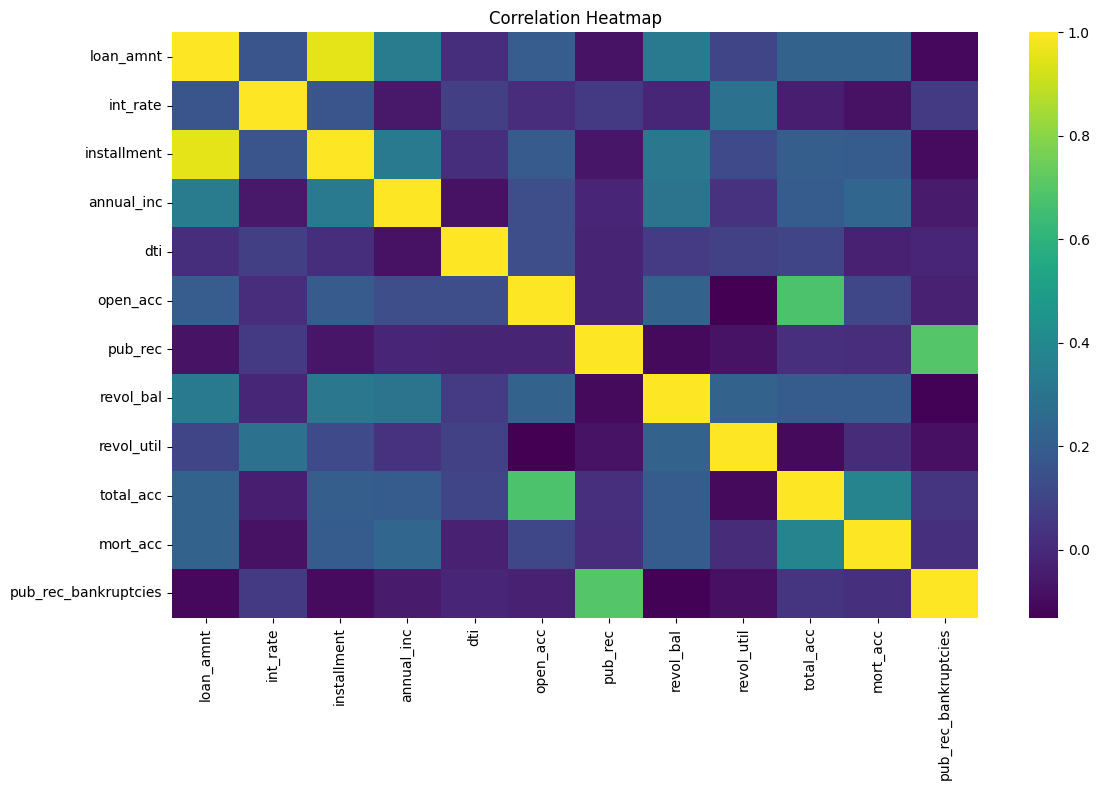

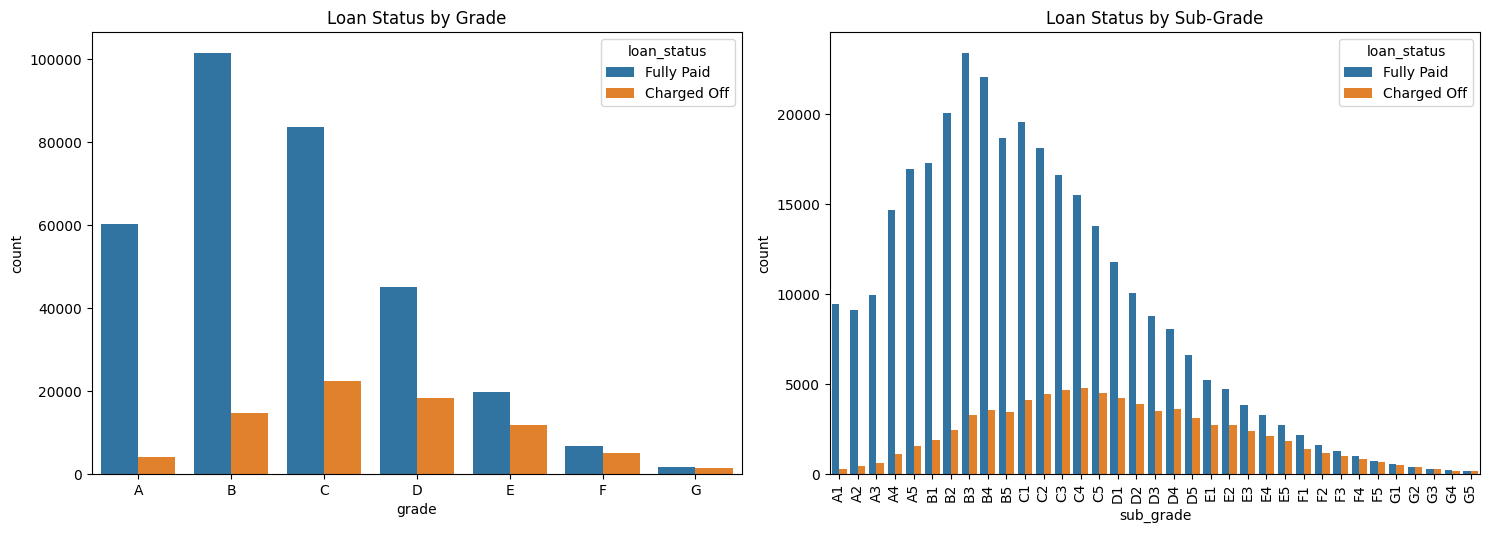

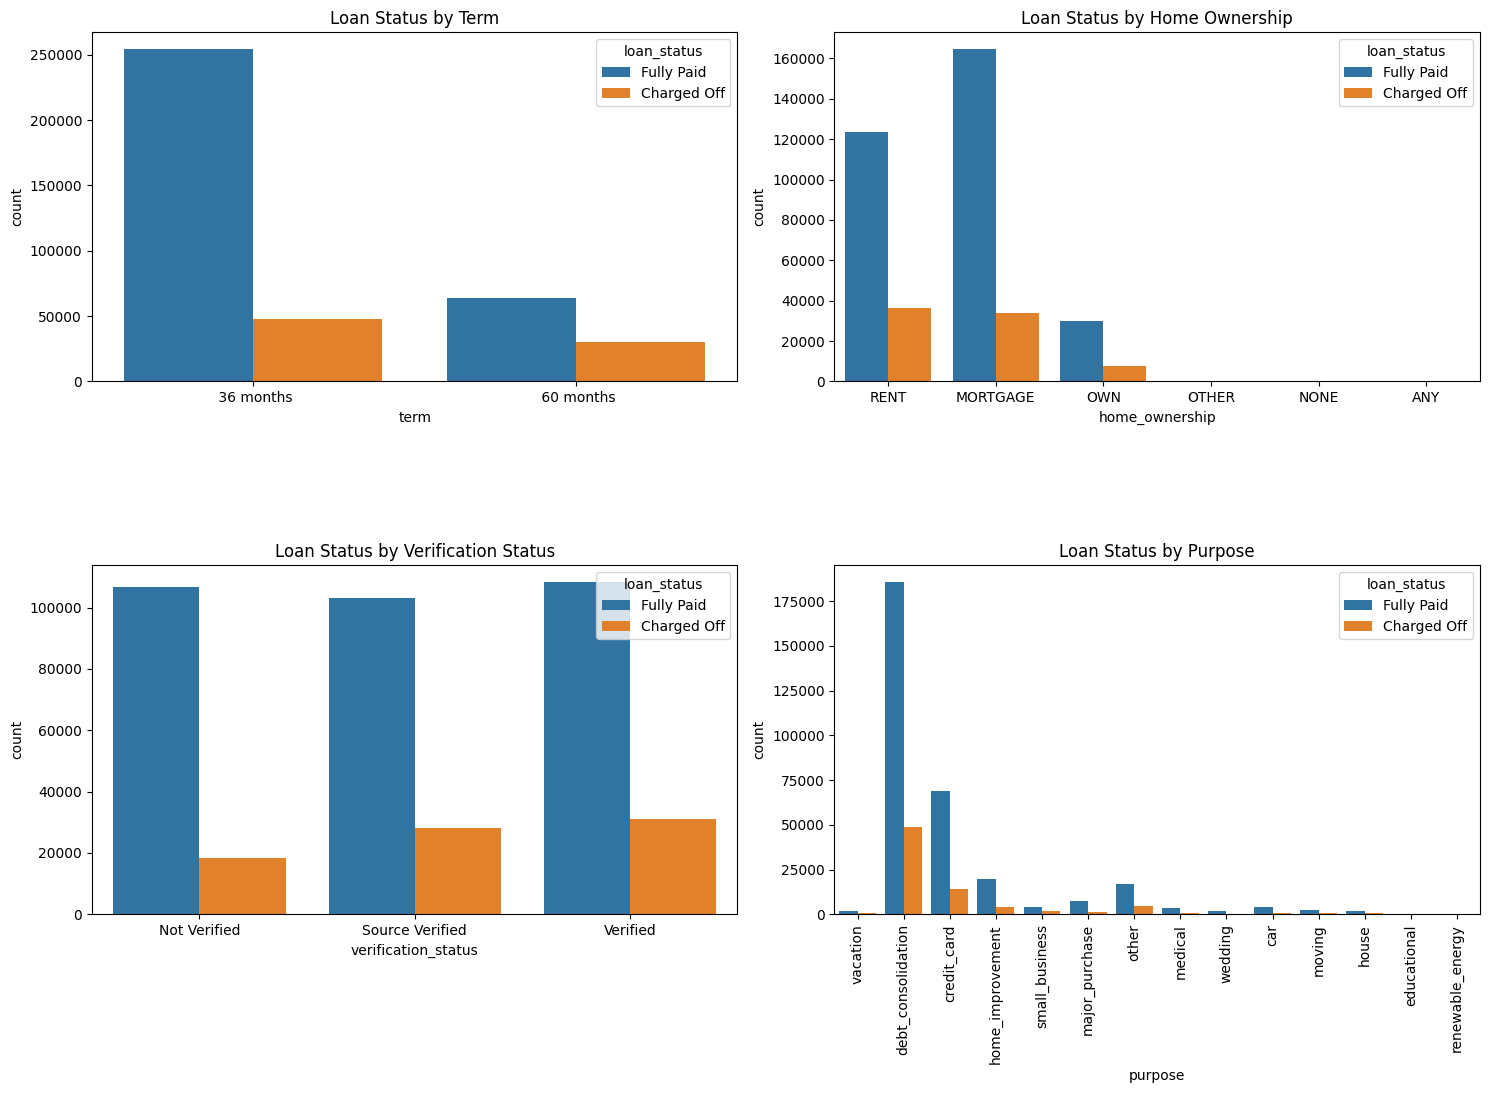

In [13]:
# Set display options
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

data = pd.read_csv("/content/drive/MyDrive/lending_club_loan_two.csv")
print(f"Data shape: {data.shape}")

print(data.head())

# Exploratory Data Analysis
print(data['loan_status'].value_counts())

print("\nBasic Statistics:")
print(data.describe())

print("\nData Info:")
print(data.info())

# Visualizations
print("\n3. Creating Visualizations...")

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.select_dtypes(include=np.number).corr(), annot=False, cmap='viridis')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Loan status by grade
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
grade = sorted(data.grade.unique().tolist())
sns.countplot(x='grade', data=data, hue='loan_status', order=grade)
plt.title('Loan Status by Grade')

plt.subplot(2, 2, 2)
sub_grade = sorted(data.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=data, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title('Loan Status by Sub-Grade')
plt.tight_layout()
plt.savefig('loan_status_by_grade.png', dpi=300, bbox_inches='tight')
plt.show()

# Categorical features
plt.figure(figsize=(15, 20))
plt.subplot(4, 2, 1)
sns.countplot(x='term', data=data, hue='loan_status')
plt.title('Loan Status by Term')

plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=data, hue='loan_status')
plt.title('Loan Status by Home Ownership')

plt.subplot(4, 2, 3)
sns.countplot(x='verification_status', data=data, hue='loan_status')
plt.title('Loan Status by Verification Status')

plt.subplot(4, 2, 4)
g = sns.countplot(x='purpose', data=data, hue='loan_status')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title('Loan Status by Purpose')
plt.tight_layout()
plt.savefig('categorical_features.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Data Preprocessing

# Handle home ownership outliers
#print("\nHandling home_ownership outliers...")
#data.loc[(data.home_ownership == 'ANY') | (data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'

# Create binary features
def pub_rec(number):
    return 0 if number == 0.0 else 1

def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

def pub_rec_bankruptcies(number):
    return 0 if number == 0.0 else (1 if number >= 1.0 else number)

data['pub_rec'] = data.pub_rec.apply(pub_rec)
data['mort_acc'] = data.mort_acc.apply(mort_acc)
data['pub_rec_bankruptcies'] = data.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

# Convert loan status to binary
data['loan_status'] = data.loan_status.map({'Fully Paid': 1, 'Charged Off': 0})

print("\n5. Handling Missing Values...")
print("\nMissing values before handling:")
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': {missing} missing values ({portion:.3f}%)")

# Drop emp_title (too many unique values)
data.drop('emp_title', axis=1, inplace=True) # Removed as it was already dropped

# Drop emp_length (weak predictor)
data.drop('emp_length', axis=1, inplace=True) # Removed as it was already dropped

# Drop title (redundant with purpose)
data.drop('title', axis=1, inplace=True) # Removed as it was already dropped

# Fill mort_acc using total_acc average
data['mort_acc'] = pd.to_numeric(data['mort_acc'], errors='coerce')
total_acc_avg = data.groupby(by='total_acc')['mort_acc'].mean()


def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

data['mort_acc'] = data.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

# Drop remaining missing values
data.dropna(inplace=True)
print(f"\nData shape after dropping missing values: {data.shape}")


5. Handling Missing Values...

Missing values before handling:
'emp_title': 22927 missing values (5.789%)
'emp_length': 18301 missing values (4.621%)
'title': 1756 missing values (0.443%)
'revol_util': 276 missing values (0.070%)
'mort_acc': 37795 missing values (9.543%)
'pub_rec_bankruptcies': 535 missing values (0.135%)

Data shape after dropping missing values: (395219, 24)


In [15]:
# ============================================================================
# 6. FEATURE ENGINEERING
# ============================================================================
print("\n6. Feature Engineering...")

# Convert term to numeric
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data['term'].apply(lambda term: int(term.strip(' months')))


# Drop grade (keep sub_grade which is more granular)
data.drop('grade', axis=1, inplace=True)

# One-hot encoding for categorical variables
dummies = ['sub_grade', 'verification_status', 'purpose', 'initial_list_status',
           'application_type']
data = pd.get_dummies(data, columns=dummies, drop_first=True)

# One-hot encoding for home_ownership (moved from previous cell)
data = pd.get_dummies(data, columns=['home_ownership'], drop_first=True)

# Extract zip code from address
data['zip_code'] = data.address.apply(lambda x: x[-5:])
data = pd.get_dummies(data, columns=['zip_code'], drop_first=True)
data.drop('address', axis=1, inplace=True)

# Drop issue_d
data.drop('issue_d', axis=1, inplace=True)

# Convert earliest_cr_line to year
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])
data['earliest_cr_line'] = data['earliest_cr_line'].dt.year

print(f"Data shape after feature engineering: {data.shape}")


6. Feature Engineering...
Data shape after feature engineering: (395219, 81)


In [16]:
# TRAIN-TEST SPLIT
train, test = train_test_split(data, test_size=0.33, random_state=42)
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


# Remove outliers from training set only
train = train[train['annual_inc'] <= 250000]
train = train[train['dti'] <= 50]
train = train[train['open_acc'] <= 40]
train = train[train['total_acc'] <= 80]
train = train[train['revol_util'] <= 120]
train = train[train['revol_bal'] <= 250000]
print(f"Train shape after outlier removal: {train.shape}")


# Separate features and target
X_train = train.drop('loan_status', axis=1)
y_train = train['loan_status']
X_test = test.drop('loan_status', axis=1)
y_test = test['loan_status']


# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to appropriate types
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

Train shape: (264796, 81)
Test shape: (130423, 81)
Train shape after outlier removal: (262143, 81)


In [18]:
#import pandas as pd
y_train = pd.Series(y_train)
y_train.value_counts(normalize=True)

,proportion
1.00,0.80
0.00,0.20


In [33]:
# ============================================================================
# 7.1 Handling Class Imbalance
# ============================================================================
print("\n7.1 Handling Class Imbalance...")

# Identify majority and minority classes for training set
majority_class_train = y_train.value_counts().idxmax()
minority_class_train = y_train.value_counts().idxmin()

# Separate majority and minority classes for training set
majority_df_train = train[train['loan_status'] == majority_class_train]
minority_df_train = train[train['loan_status'] == minority_class_train]

# Determine target size for undersampling majority class in training set
majority_undersample_size_train = len(majority_df_train) // 2

# Undersample majority class in training set
majority_undersampled_train = majority_df_train.sample(n=majority_undersample_size_train, random_state=42)

# Determine target size for upsampling minority class in training set (to match undersampled majority)
minority_upsample_size_train = majority_undersample_size_train

# Upsample minority class in training set
minority_upsampled_train = minority_df_train.sample(n=minority_upsample_size_train, replace=True, random_state=42)

# Combine the balanced training dataframes
balanced_train = pd.concat([majority_undersampled_train, minority_upsampled_train])

# Shuffle the balanced training dataframe
balanced_train = balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced Train shape: {balanced_train.shape}")
print("\nBalanced Train Loan Status Distribution:")
print(balanced_train['loan_status'].value_counts(normalize=True))

# Separate features and target for balanced training data
X_train_bal = balanced_train.drop('loan_status', axis=1)
y_train_bal = balanced_train['loan_status']

# Convert y_test to pandas Series before balancing
y_test_series = pd.Series(y_test)

# Identify majority and minority classes for test set
majority_class_test = y_test_series.value_counts().idxmax()
minority_class_test = y_test_series.value_counts().idxmin()

# Separate majority and minority classes for test set
majority_df_test = test[test['loan_status'] == majority_class_test]
minority_df_test = test[test['loan_status'] == minority_class_test]


# Determine target size for undersampling majority class in test set
majority_undersample_size_test = len(majority_df_test) // 2

# Undersample majority class in test set
majority_undersampled_test = majority_df_test.sample(n=majority_undersample_size_test, random_state=42)

# Determine target size for upsampling minority class in test set (to match undersampled majority)
minority_upsample_size_test = majority_undersample_size_test

# Upsample minority class in test set
minority_upsampled_test = minority_df_test.sample(n=minority_upsample_size_test, replace=True, random_state=42)

# Combine the balanced test dataframes
balanced_test = pd.concat([majority_undersampled_test, minority_upsampled_test])

# Shuffle the balanced test dataframe
balanced_test = balanced_test.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nBalanced Test shape: {balanced_test.shape}")
print("\nBalanced Test Loan Status Distribution:")
print(balanced_test['loan_status'].value_counts(normalize=True))

# Separate features and target for balanced test data
X_test_bal = balanced_test.drop('loan_status', axis=1)
y_test_bal = balanced_test['loan_status']


# Scale balanced features
scaler_bal = MinMaxScaler()
X_train_bal = scaler_bal.fit_transform(X_train_bal)
X_test_bal = scaler_bal.transform(X_test_bal) # Scale test data using the same scaler fit on training data

# Convert to appropriate types
X_train_bal = np.array(X_train_bal).astype(np.float32)
y_train_bal = np.array(y_train_bal).astype(np.float32)
X_test_bal = np.array(X_test_bal).astype(np.float32)
y_test_bal = np.array(y_test_bal).astype(np.float32)


7.1 Handling Class Imbalance...
Balanced Train shape: (210478, 81)

Balanced Train Loan Status Distribution:
loan_status
0   0.50
1   0.50
Name: proportion, dtype: float64

Balanced Test shape: (104942, 81)

Balanced Test Loan Status Distribution:
loan_status
1   0.50
0   0.50
Name: proportion, dtype: float64


In [21]:
# MODEL BUILDING

# Helper functions
def print_score(true, pred, train=True):
    clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))

    if train:
        print("Train Result:\n" + "=" * 50)
    else:
        print("Test Result:\n" + "=" * 50)

    print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
    print("-" * 50)
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print("-" * 50)
    print(f"Confusion Matrix:\n{confusion_matrix(true, pred)}\n")

def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss Evolution During Training')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC Score Evolution During Training')
    plt.legend()
    plt.tight_layout()
    plt.savefig('neural_network_training.png', dpi=300, bbox_inches='tight')
    plt.show()

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = Input(shape=(num_columns,))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)

    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)

    x = Dense(num_labels, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=[AUC(name='AUC')])
    return model

Epoch 1/7
6578/6578 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - AUC: 0.8493 - loss: 0.4569 - val_AUC: 0.8976 - val_loss: 0.3795
Epoch 2/7
6578/6578 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - AUC: 0.8752 - loss: 0.4152 - val_AUC: 0.9032 - val_loss: 0.3689
Epoch 3/7
6578/6578 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - AUC: 0.8795 - loss: 0.4052 - val_AUC: 0.9038 - val_loss: 0.3665
Epoch 4/7
6578/6578 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - AUC: 0.8826 - loss: 0.4000 - val_AUC: 0.9037 - val_loss: 0.3680
Epoch 5/7
6578/6578 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - AUC: 0.8848 - loss: 0.3967 - val_AUC: 0.9016 - val_loss: 0.3755
Epoch 6/7
6578/6578 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - AUC: 0.8837 - loss: 0.3977 - val_AUC: 0.9037 - val_loss: 0.3793
Epoch 7/7
6578/6578 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - AUC: 0.8852 - loss: 0.3953 - val_AUC: 0.9046 - val_loss: 0.3680


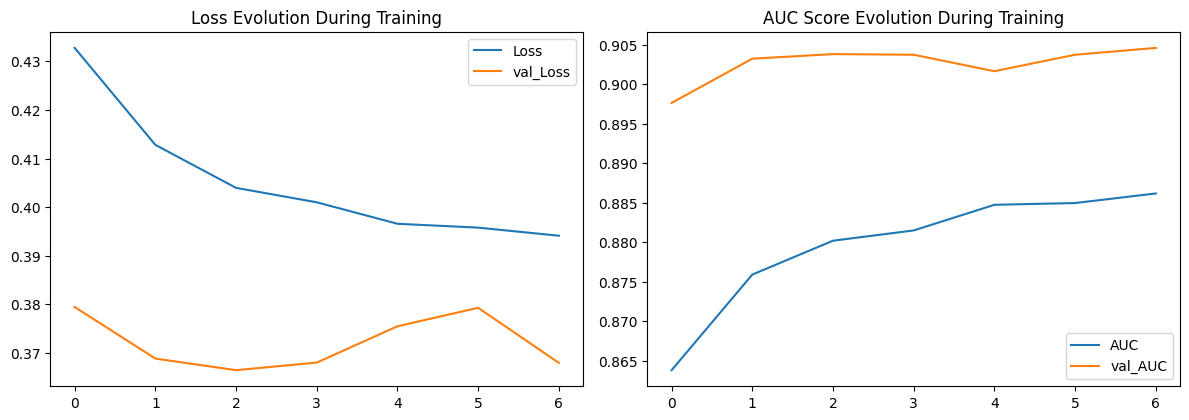


ANN Training Results:
6578/6578 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Train Result:
Accuracy Score: 80.54%
--------------------------------------------------
CLASSIFICATION REPORT:
                0.0       1.0  accuracy  macro avg  weighted avg
precision      0.77      0.85      0.81       0.81          0.81
recall         0.86      0.75      0.81       0.81          0.81
f1-score       0.82      0.79      0.81       0.80          0.80
support   105239.00 105239.00      0.81  210478.00     210478.00
--------------------------------------------------
Confusion Matrix:
[[90991 14248]
 [26715 78524]]


ANN Test Results:
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Test Result:
Accuracy Score: 79.99%
--------------------------------------------------
CLASSIFICATION REPORT:
               0.0      1.0  accuracy  macro avg  weighted avg
precision     0.77     0.84      0.80       0.80          0.80
recall        0.86     0.74      0.80       0.80          0.80
f1-score      0.81     0.79      0.

In [35]:
# ARTIFICIAL NEURAL NETWORK
num_columns = X_train_bal.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3

ann_model = nn_model(
    num_columns=num_columns,
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)

r = ann_model.fit(
    X_train_bal, y_train_bal,
    validation_data=(X_test_bal, y_test_bal),
    epochs=7,
    batch_size=32,
    verbose=1
)

plot_learning_evolution(r)

print("\nANN Training Results:")
y_train_pred = ann_model.predict(X_train_bal)
print_score(y_train_bal, y_train_pred.round(), train=True)

print("\nANN Test Results:")
y_test_pred = ann_model.predict(X_test_bal)
print_score(y_test_bal, y_test_pred.round(), train=False)

scores_dict = {
    'ANNs': {
        'Train': roc_auc_score(y_train_bal, ann_model.predict(X_train_bal)),
        'Test': roc_auc_score(y_test_bal, ann_model.predict(X_test_bal)),
    },
}



XGBoost Training Results:
Train Result:
Accuracy Score: 84.45%
--------------------------------------------------
CLASSIFICATION REPORT:
                0.0       1.0  accuracy  macro avg  weighted avg
precision      0.84      0.85      0.84       0.84          0.84
recall         0.85      0.84      0.84       0.84          0.84
f1-score       0.85      0.84      0.84       0.84          0.84
support   105239.00 105239.00      0.84  210478.00     210478.00
--------------------------------------------------
Confusion Matrix:
[[89634 15605]
 [17129 88110]]


XGBoost Test Results:
Test Result:
Accuracy Score: 80.33%
--------------------------------------------------
CLASSIFICATION REPORT:
               0.0      1.0  accuracy  macro avg  weighted avg
precision     0.81     0.80      0.80       0.80          0.80
recall        0.79     0.82      0.80       0.80          0.80
f1-score      0.80     0.81      0.80       0.80          0.80
support   52471.00 52471.00      0.80  104942.00   

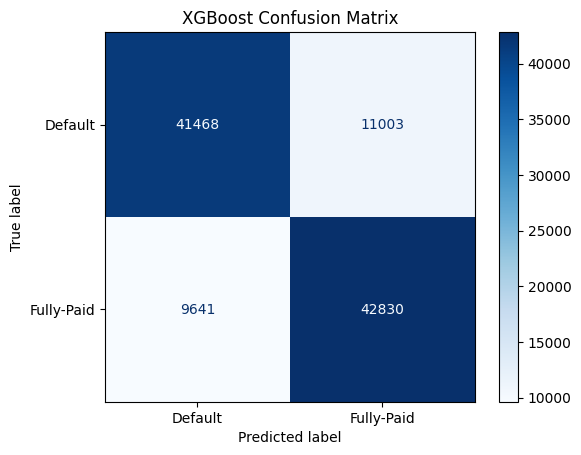

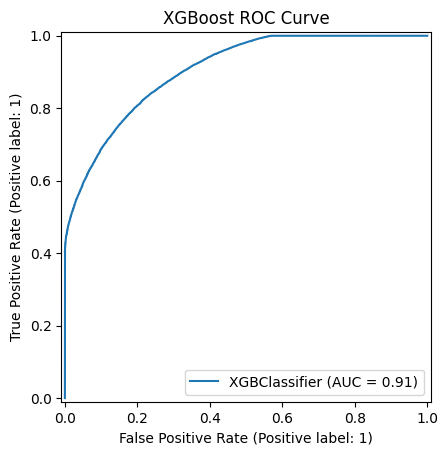

In [36]:
# XGBOOST CLASSIFIER

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_bal, y_train_bal)

print("\nXGBoost Training Results:")
y_train_pred = xgb_clf.predict(X_train_bal)
print_score(y_train_bal, y_train_pred, train=True)

print("\nXGBoost Test Results:")
y_test_pred = xgb_clf.predict(X_test_bal)
print_score(y_test_bal, y_test_pred, train=False)

# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_clf, X_test_bal, y_test_bal,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)
plt.title('XGBoost Confusion Matrix')
plt.savefig('xgboost_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
disp = RocCurveDisplay.from_estimator(xgb_clf, X_test_bal, y_test_bal)
plt.title('XGBoost ROC Curve')
plt.savefig('xgboost_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

scores_dict['XGBoost'] = {
    'Train': roc_auc_score(y_train_bal, xgb_clf.predict(X_train_bal)),
    'Test': roc_auc_score(y_test_bal, xgb_clf.predict(X_test_bal)),
}



Random Forest Training Results:
Train Result:
Accuracy Score: 100.00%
--------------------------------------------------
CLASSIFICATION REPORT:
                0.0       1.0  accuracy  macro avg  weighted avg
precision      1.00      1.00      1.00       1.00          1.00
recall         1.00      1.00      1.00       1.00          1.00
f1-score       1.00      1.00      1.00       1.00          1.00
support   105239.00 105239.00      1.00  210478.00     210478.00
--------------------------------------------------
Confusion Matrix:
[[105238      1]
 [     0 105239]]


Random Forest Test Results:
Test Result:
Accuracy Score: 76.97%
--------------------------------------------------
CLASSIFICATION REPORT:
               0.0      1.0  accuracy  macro avg  weighted avg
precision     0.91     0.70      0.77       0.80          0.80
recall        0.60     0.94      0.77       0.77          0.77
f1-score      0.72     0.80      0.77       0.76          0.76
support   52471.00 52471.00      0

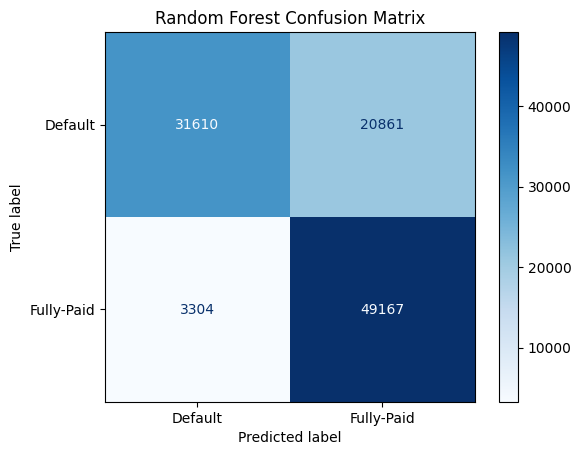

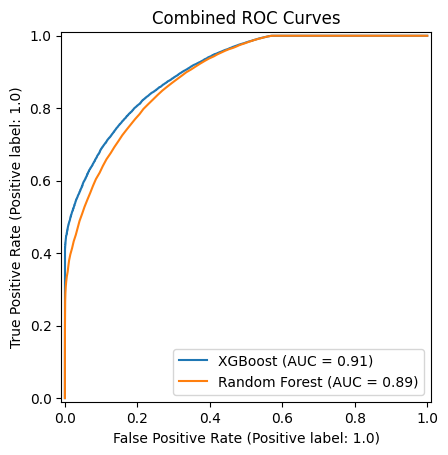

In [37]:
# RANDOM FOREST CLASSIFIER

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_bal, y_train_bal)

print("\nRandom Forest Training Results:")
y_train_pred = rf_clf.predict(X_train_bal)
print_score(y_train_bal, y_train_pred, train=True)

print("\nRandom Forest Test Results:")
y_test_pred = rf_clf.predict(X_test_bal)
print_score(y_test_bal, y_test_pred, train=False)

# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf, X_test_bal, y_test_bal,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)
plt.title('Random Forest Confusion Matrix')
plt.savefig('random_forest_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Combined ROC Curves
disp = RocCurveDisplay.from_estimator(xgb_clf, X_test_bal, y_test_bal, name='XGBoost')
RocCurveDisplay.from_estimator(rf_clf, X_test_bal, y_test_bal, ax=disp.ax_, name='Random Forest')
plt.title('Combined ROC Curves')
plt.savefig('combined_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

scores_dict['Random Forest'] = {
    'Train': roc_auc_score(y_train_bal, rf_clf.predict(X_train_bal)),
    'Test': roc_auc_score(y_test_bal, rf_clf.predict(X_test_bal)),
}


ROC AUC SCORES:
Random Forest                  ROC AUC Score: 0.7697
XGBoost                        ROC AUC Score: 0.8033
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
ANNs                           ROC AUC Score: 0.9046

SUMMARY TABLE:
       ANNs  XGBoost  Random Forest
Train  0.91     0.84           1.00
Test   0.90     0.80           0.77


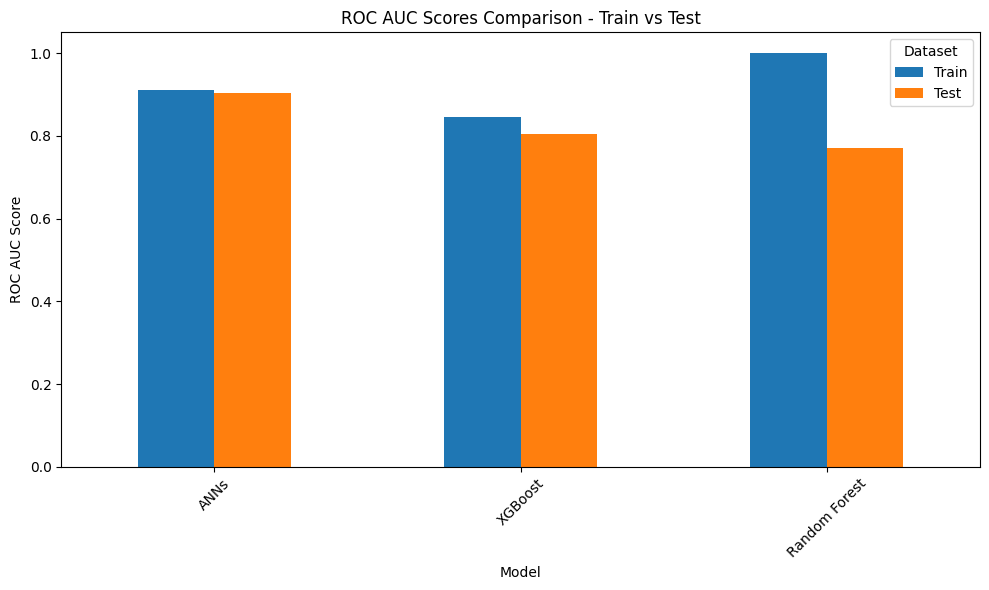

In [38]:
# MODEL COMPARISON

print("\nROC AUC SCORES:")


ml_models = {
    'Random Forest': rf_clf,
    'XGBoost': xgb_clf,
    'ANNs': ann_model
}

for model_name in ml_models:
    model = ml_models[model_name]
    roc_score = roc_auc_score(y_test_bal, model.predict(X_test_bal) if model_name != 'ANNs' else model.predict(X_test_bal))
    print(f"{model_name:30} ROC AUC Score: {roc_score:.4f}")

# Visualize scores
scores_df = pd.DataFrame(scores_dict)
print("\n" + "=" * 80)
print("SUMMARY TABLE:")
print("=" * 80)
print(scores_df)

# Plot comparison
scores_df.T.plot(kind='bar', figsize=(10, 6))
plt.title('ROC AUC Scores Comparison - Train vs Test')
plt.xlabel('Model')
plt.ylabel('ROC AUC Score')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()